In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.stats import *

import colormaps
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2
%matplotlib inline

figure_subfolder = "jet_props_wet"
figure_subfolder = f"{FIGURES}/{figure_subfolder}"

In [11]:
exp_tp = ExtremeExperiment(
    DataHandler("ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None),
    q=0.9
)
da_tp = exp_tp.da.load()

data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds = exp.props_as_ds(True)

In [12]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = np.timedelta64(0, "D")
minlen = np.timedelta64(12, "h")
n_clu = 6
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
create_targets_kwargs = dict(
    n_clu=n_clu,
    q=exp_tp.q,
    time_before=time_before,
    minlen=minlen,
    fill_holes=1,
)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(**create_targets_kwargs)
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
binary_targets.sum("time")

<xarray.DataArray (region: 6)> Size: 48B
array([283,  95, 136,  79,  73, 585])
Coordinates:
  * region   (region) int64 48B 0 1 2 3 4 5

# Half van straaten

In [14]:
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
    lags=[0, 4, 8, 16],
)

full_pred, feature_importances, raw_shap = exp_tp.full_prediction(
    predictors,
    create_target_kwargs=create_targets_kwargs,
    type_="xgb",
    do_base_pred=True,
    prediction_kwargs=dict(
        max_depth=11,
        n_estimators=1000
    )
)

  0%|          | 0/24 [00:00<?, ?it/s]

[20:52:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:52:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:53:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using 

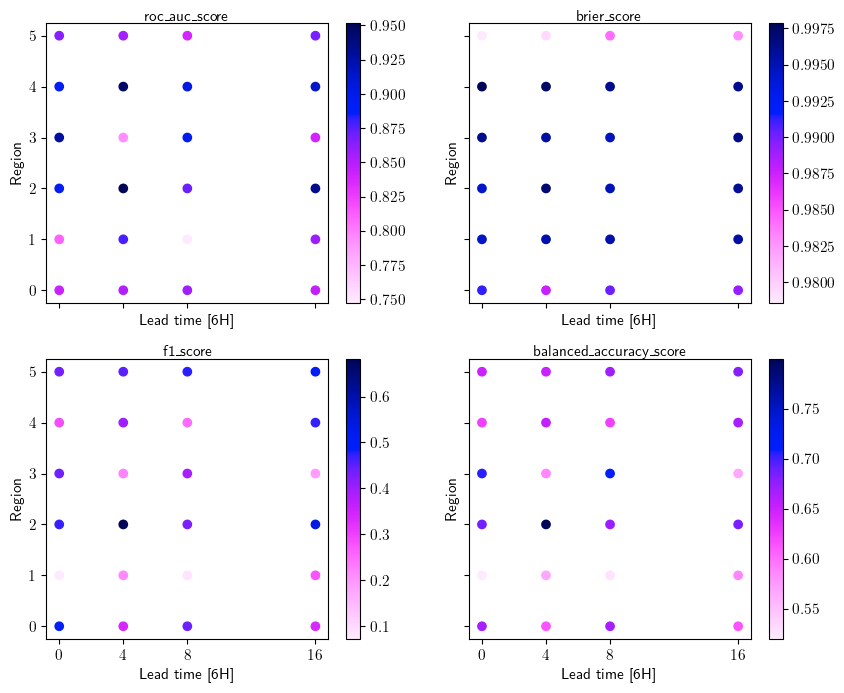

In [15]:
x = full_pred.lag.values
y = full_pred.region.values
s = {
    "roc_auc_score": full_pred.roc_auc_score.values,
    "brier_score": full_pred.brier_score.values,
    "f1_score": full_pred.f1_score.values,
    "balanced_accuracy_score": full_pred.balanced_accuracy_score.values,
}
cmap = colormaps.cet_l_bmw1_r
fig, axes = plt.subplots(2, len(s) // 2, figsize=(10, 8), sharex="all", sharey="all")
for (scorename, s_), ax in zip(s.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=s_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel("Lead time [6H]")
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel("Region")
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


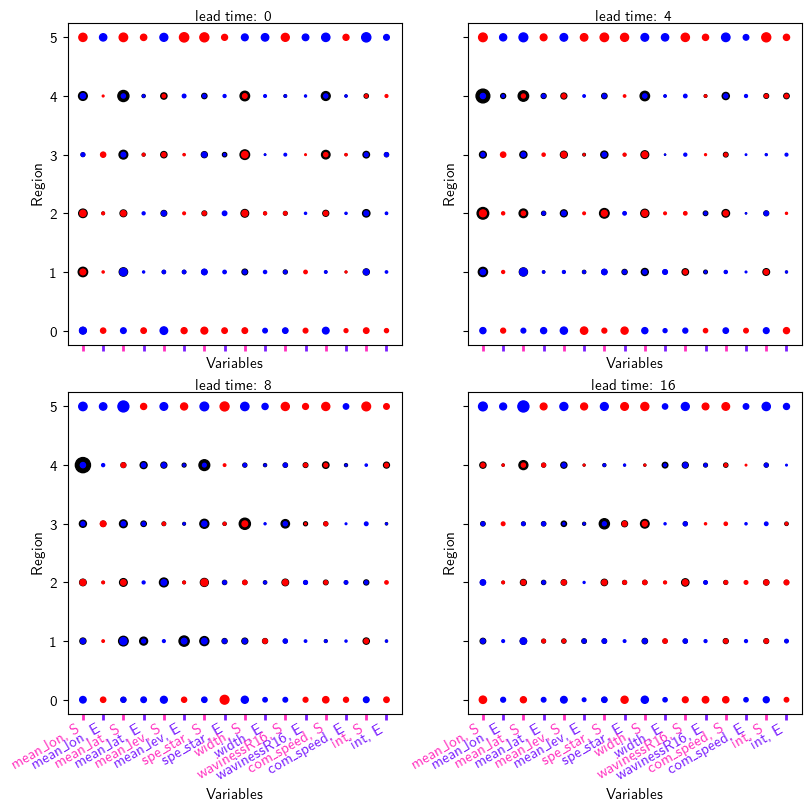

In [17]:
varnames, index_ = np.unique(predictors.varname.values, return_index=True)
varnames = varnames[np.argsort(index_)]
jets, index_ = np.unique(predictors.jet.values, return_index=True)
jets = jets[np.argsort(index_)]

lead_times = predictors.lag.values
regions = feature_importances.region.values
x = np.arange(len(varnames) * len(jets))
y = np.arange(len(regions))
meshgrid = np.meshgrid(x, y)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True, sharey='all', sharex="all")

for ax, lead_time in zip(axes.ravel(), lead_times):
    s1 = feature_importances.loc["permutation", :, :, lead_time]
    s2 = feature_importances.loc["mean_abs_shap", :, :, lead_time]
    c = feature_importances.loc["correlation", :, :, lead_time]
    s1 = s1.values.reshape(len(x), len(y))
    s2 = s2.values.reshape(len(x), len(y))
    c = np.sign(c.values.reshape(len(x), len(y)))
    x = np.arange(s1.shape[0])
    y = np.arange(s1.shape[1])
    ax.scatter(*meshgrid, s=s1.T * 100, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2.T * 5000, c=np.sign(c).T, cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Variables')
    xticks = ax.set_xticks(np.unique(x), [f"{varname}, {SHORTHAND[jet][0]}" for varname in varnames for jet in jets], rotation=30, ha="right")
    ax.set_ylabel('Region')
    ax.set_yticks(y, regions)
    ax.set_title(f'lead time: {lead_time}')
    ax.tick_params(axis="x", length=4, width=2, pad=1)
    for i, tick in enumerate(xticks):
        tick._apply_params(color=COLORS[1 + (i + 1) % 2], labelcolor=COLORS[1 + (i + 1) % 2])
# plt.savefig(f"{figure_subfolder}/vanstraaten_importance.png")

In [ ]:
varnames = predictors.varname.values[::6]
jets = predictors.jet.values[[0, 3]]
feature_timscales = np.unique(predictors.timescale.values)
lead_times = predictors.lag.values
regions = feature_importances.region.values
x = np.arange(len(varnames) * len(jets))
y = np.arange(len(feature_timscales))
meshgrid = np.meshgrid(x, y)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True, sharey='all', sharex="all")
region = 2

for ax, lead_time in zip(axes.ravel(), lead_times):
    s1 = feature_importances.loc["permutation", :, region, lead_time]
    s2 = feature_importances.loc["mean_abs_shap", :, region, lead_time]
    c = feature_importances.loc["correlation", :, region, lead_time]
    s1 = s1.values.reshape(len(x), len(y))
    s2 = s2.values.reshape(len(x), len(y))
    c = np.sign(c.values.reshape(len(x), len(y)))
    x = np.arange(s1.shape[0])
    y = np.arange(s1.shape[1])
    ax.scatter(*meshgrid, s=s1.T * 2000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2.T * 5000, c=np.sign(c).T, cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Variables')
    xticks = ax.set_xticks(np.unique(x), [f"{varname}, {SHORTHAND[jet][0]}" for varname in varnames for jet in jets], rotation=30, ha="right")
    ax.set_ylabel('Feature timescale')
    ax.set_yticks(y, feature_timscales)
    ax.set_title(f'lead time: {lead_time}, region: {region}')
    ax.tick_params(axis="x", length=4, width=2, pad=1)
    for i, tick in enumerate(xticks):
        tick._apply_params(color=COLORS[1 + (i + 1) % 2], labelcolor=COLORS[1 + (i + 1) % 2])
# plt.savefig(f"{figure_subfolder}/vanstraaten_importance.png")

# Correlations prec extremes <-> predictors

In [ ]:
corr_da = compute_all_responses(predictors, xrft.detrend(da_tp, "time", "linear"), [0])

In [ ]:
clu = Clusterplot(8, 2, get_region(corr_da))
_ = clu.add_contourf(corr_da.squeeze(), titles=corr_da.predictor.values, cmap="bwr", transparify=0, cbar_kwargs={"orientation": "horizontal", "pad": 0.01, "shrink": 0.7}, levels=6, q=0.95)
clu.resize_relative([0.9, 1.0])
plt.savefig(f"{figure_subfolder}/jet_props_corr.png")

# Visualize clusters

In [ ]:
clu = Clusterplot(1, 1, exp_tp.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

# Jet indices during high prec extremes at region $R$

In [ ]:
quantiles = predictors.quantile([0.25, 0.75], dim="time")
lon, lat = clusters_da.lon.values, clusters_da.lat.values
spell_means = masked_predictors.mean(dim=["spell", "time_around_beg"])
predictor_names = masked_predictors.predictor.values
to_plot = []
for spell_mean, quantile in zip(spell_means.transpose("predictor", ...), quantiles.transpose("predictor", ...)):
    vals = np.digitize(spell_mean, quantile)
    to_plot_ = clusters_da.copy()
    for n, val in zip(spell_mean.region.values, vals):
        to_plot_ = to_plot_.where(clusters_da != n, val)
    to_plot.append(to_plot_)
clu = Clusterplot(len(spell_means.predictor) // 2, 2, exp_tp.region, coastline=False)
cmap = colormaps.cet_d_bwr
norm = BoundaryNorm(np.arange(-0.5, 3.5), cmap.N)
clu.fig.colorbar(ScalarMappable(norm, cmap), ax=clu.axes, shrink=0.6, ticks=[0, 1, 2], orientation="horizontal", pad=0.01)
for ax, predictor_name, to_plot_ in zip(clu.axes.ravel(), predictor_names, to_plot):
    to_plot_.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)
    ax.set_title(predictor_name, pad=4)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="black", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="black")
clu.resize_relative([0.9, 1.0])
plt.savefig(f"{figure_subfolder}/jet_props_quantiles.png")

# Multi combination regression like García-Burgos

In [ ]:
best_combinations, best_combination, path = exp_tp.multi_combination_prediction(
    predictors,
    create_target_kwargs=create_target_kwargs,
    type_="rf",
    do_base_pred=True,
    max_n_predictors=10,
    winner_according_to="roc_auc_score",
)

In [ ]:
max_n_predictors = len(best_combinations["region=1"]) + 1
n_clu = len(best_combinations)
cmap = colormaps.BlAqGrYeOrReVi200
norm = BoundaryNorm(np.concatenate([[-1], np.arange(n_clu)]) + 0.5, cmap.N)
colors = cmap(norm(np.arange(n_clu)))
x = np.arange(1, max_n_predictors)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex="all", sharey="all")
all_scores = []
for (regionkey, best_combinations_), color in zip(best_combinations.items(), colors):
    ri = int(regionkey.split("=")[-1])
    df = []
    for n in x:
        bcs = best_combinations_[n][0]
        df.append({scorekey: bcs[scorekey].item() for scorekey in ALL_SCORES})
    df = pd.DataFrame(df)
    all_scores.append(df)
    for ax, sn in zip(axes.ravel(), df):
        series = df[sn]
        ax.plot(x, series.values, label=ri, lw=2, color=color)
for i, (ax, title) in enumerate(zip(axes.ravel(), ALL_SCORES)):
    ax.set_xlabel("predictors")
    ax.set_ylabel(title)
axes.ravel()[0].legend(ncol=4)
plt.savefig(f"{figure_subfolder}/prediction_skills.png")

In [ ]:
from matplotlib.ticker import MaxNLocator
lon, lat = clusters_da.lon.values, clusters_da.lat.values

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

best_scores = pd.DataFrame([{score_name: combination[0][score_name].item() for score_name in ALL_SCORES} for combination in best_combination.values()]).values.T
clu = Clusterplot(2, 2, exp_tp.region)

for to_plot_, title, ax in zip(best_scores, ALL_SCORES, clu.axes):
    to_plot = assign_to_regions(clusters_da, to_plot_)
    cmap = colormaps.bubblegum_r
    levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
    cbar_kwargs = {"shrink": 0.85}
    norm = BoundaryNorm(levels, cmap.N)
    to_plot.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=cbar_kwargs, add_labels=False)
    ax.set_title(title)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="white", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="white")
plt.savefig(f"{FIGURES}/jet_props_prec/prediction_skill_map.png")

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
lon, lat = clusters_da.lon.values, clusters_da.lat.values

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

clu = Clusterplot(1, 1, get_region(clusters_da), coastline=False)
ax0 = clu.axes[0]
cmap = colormaps.BlAqGrYeOrReVi200
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
clusters_da.unstack().plot(
    ax=ax0,
    # colors="gainsboro", 
    # levels=[0.99, 1.5],
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False,
    alpha=0.2
)

score_name = "balanced_accuracy_score"
to_plot = [combination[0][score_name].item() for combination in best_combination.values()]
to_plot = assign_to_regions(clusters_da, to_plot)
cmap_score = colormaps.bubblegum_r
levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
cbar_kwargs = {"shrink": 0.84, "label": score_name, "pad": 0.02}
norm_score = BoundaryNorm(levels, cmap_score.N)
clu.fig.colorbar(ScalarMappable(norm_score, cmap_score), ax=ax0, **cbar_kwargs)

all_preds = np.arange(len(predictors.predictor))
cmap = colormaps.bold
norm = BoundaryNorm(np.arange(cmap.N) - 0.5, cmap.N)
colors = cmap(norm(all_preds // 2))
colors = pd.Series(dict(zip(predictors.predictor.values, colors)))
hatchstyle1 = np.asarray(["", "..."])
hatchstyle2 = np.asarray(["", ".."])
hatches = hatchstyle1[all_preds % 2]
hatches = pd.Series(dict(zip(predictors.predictor.values, hatches)))
dx, dy = 7, 7
size = 0.6
explode = 0.0
radius = 1.
pie_kwargs1 = {
    "wedgeprops": dict(width=size),
    "radius": radius,
}
pie_kwargs2 = {
    "wedgeprops": dict(zorder=3),
    "radius": radius * (1.0 + explode - size),
}
patch = dict(boxstyle='round', facecolor='white', alpha=1.0)
for regionkey, combination in best_combination.items():
    n = int(regionkey.split("=")[-1])
    lo = clusters_da.lon.where(clusters_da==n).mean().item()
    la = clusters_da.lat.where(clusters_da==n).mean().item()
    # ax0.contourf(lon, lat, (clusters_da == n).astype(int), colors="gainsboro", levels=[0.99, 1.5], zorder=10, transform=ccrs.PlateCarree())
    a = ax0.contour(lon, lat, (clusters_da == n).astype(int), colors="black", levels=[0.5], zorder=10, linewidths=1, transform=ccrs.PlateCarree())
    ax0.text(lo, la, f"{n + 1}", ha="center", va="center_baseline", ma="center", fontweight="bold", color="white", zorder=14, usetex=False, fontsize=9)
    pathpatch = a.get_paths()[0].to_polygons()[0] # TODO: Need to resize and center
    thisax = ax0.inset_axes([lo - dx / 2, la - dy / 2, dx, dy], transform=ax0.transData, zorder=13)
    score = combination[0][score_name]
    to_app = combination[1]
    keys = combination[2]
    asdict = pd.Series(dict(zip(keys, np.around(to_app.sel(type="impurity").values, 2)))).sort_values(ascending=False)
    is_neg = to_app.sel(type="correlation").values < 0
    colors_ = colors.loc[keys].values
    hatches_ = hatches.loc[keys].values
    hatches_ = hatches_
    pred_imp_ = np.clip(asdict.values, 0, None)
    patches = thisax.pie(pred_imp_, explode=len(pred_imp_) * [explode], colors=colors_, hatch=hatches_, **pie_kwargs1)[0]
    for patch, is_neg_ in zip(patches, is_neg):
        if is_neg_:
            patch.set_linewidth(2)
            patch.set_edgecolor("k")
            patch.set_zorder(2)
    thisax.pie([1.], colors=[cmap_score(norm_score(score))], **pie_kwargs2)
    
legend_elements = [
    Patch(facecolor=cmap(norm(i)), edgecolor="black", label=PRETTIER_VARNAME[varname], linewidth=0) for i, varname in enumerate(subset)
]
jets = props_as_ds.jet.values
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=SHORTHAND[jet], hatch=hatch, linewidth=0) for jet, hatch in zip(jets, hatchstyle1)
])
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=sign_, linewidth=linewidth) for sign_, linewidth in zip(["pos. correlation", "neg. correlation"], [0, 2])
])
clu.fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.9, 0.5))
clu.fig.set_tight_layout(False)
plt.savefig(f"{figure_subfolder}/predictor_importance.png")

# Jet index anoms around extreme

In [ ]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = np.timedelta64(3, "D")
minlen = np.timedelta64(12, "h")
n_clu = 22
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
create_target_kwargs=dict(n_clu=n_clu, q=0.95, minlen=minlen, time_before=time_before)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(**create_target_kwargs)
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

In [ ]:
all_preds = np.arange(len(predictors.predictor))
cmap = colormaps.bold
norm = BoundaryNorm(np.arange(cmap.N) - 0.5, cmap.N)
colors = cmap(norm(all_preds // 2))
colors = pd.Series(dict(zip(predictors.predictor.values, colors)))
linestyles = np.asarray(["solid", "dashed"])[all_preds % 2]
linestyles = pd.Series(dict(zip(predictors.predictor.values, linestyles)))
masked_predictors_ = masked_predictors.isel(time_around_beg=slice(6, 19))
x = masked_predictors_.time_around_beg.values.astype("timedelta64[h]")
fig, axes = plt.subplots(11, 2, figsize=(TEXTWIDTH_IN, 13), tight_layout=True, sharex="all", sharey="all")
for ax, (identifier, combination) in zip(axes.ravel(), best_combination.items()):
    ri = int(identifier.split("=")[-1])
    these_preds = combination[-1]
    mpreds = masked_predictors_.isel(region=ri)
    for pred in these_preds:
        y = mpreds.sel(predictor=pred).mean(dim="spell").values
        ax.plot(x, y, color=colors[pred], ls=linestyles[pred], lw=2)
        
    ax.grid()
    ax.set_title(identifier)
    ax.set_ylim([-1, 1])
plt.savefig(f'{figure_subfolder}/jet_props_around_spell.png')

# Jet position around heat waves

In [ ]:
jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)

In [ ]:
da_jet_pos_masked = mask_from_t(da_cee, jet_pos_da, q=0.9, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

In [ ]:
timesteps = np.arange(0, 32)
timesteps = np.arange(0, 32)
timesteps_ = np.split(timesteps, 8)
this_da = da_jet_pos_masked.mean(dim="heat_wave")
to_plot_subtropical = [this_da.isel(time_around_beg=tag, jet=0).mean("time_around_beg") for tag in timesteps_]
to_plot_polar = [this_da.isel(time_around_beg=tag, jet=1).mean("time_around_beg") for tag in timesteps_]
clu = Clusterplot(len(timesteps_) // 4, 4, region=get_region(this_da))
_ = clu.add_contourf(to_plot_polar, cmap='Purples', transparify=2, draw_cbar=False, q=0.95)
_ = clu.add_contourf(to_plot_subtropical, cmap='Greens', transparify=2, draw_cbar=False, q=0.95)
# plt.savefig('/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_index_extremes_composites/jet_index_vs_jet_pos.png')